# Configuration

## Modules

In [122]:
import pandas as pd
import seaborn as sb
import nltk
from scipy import stats
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import time
import random
import os
import re
import numpy as np
from gensim import corpora
from gensim.models import CoherenceModel 
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')


!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim_models


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Constants

In [123]:
INPUT_FILE = '/content/drive/MyDrive/MA5851_A3/scrape_results.csv'
TEXT_COLUMN ="Bag Of Words"
STOP_WORDS = stopwords.words('english')
EXTENDED_STOP_WORDS = ['m','u','also','est','span','a','n','said','time','one'] 
EXCLUDE_CHARACTERS = set(string.punctuation)
TOKENIZER_FUNCTION = WordNetLemmatizer().lemmatize
NUM_TOPICS=12
PASSES=50
MINIMUM_PROBABILITY=0.0
#Set bigram, trigram, etc
GRAM_N = 2
DELIMITER = b' '
NUM_TOPICS = [3,5,7]
ALPHA = 0.1
SEED = 42

## File Storage

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [125]:
def Clean(doc, tokenizer, exclude, stop):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(tokenizer(word) for word in punc_free.split())
    return normalized

In [126]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  # deacc = True removes punctuations

In [127]:
def Make_Ngrams(texts, gram_mod):
    return [gram_mod[doc] for doc in texts]

In [128]:
def Get_Tuple_Value(tup: tuple, x: int):
  return tup[x]

In [129]:
def Filter_By_P_Value(coef, p_values, alpha):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j > alpha:
              output.loc[i, column] = float("NaN")
      return output

def Add_P_Value_Markers(coef, p_values, alpha, character):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j < alpha:
              output.loc[i, column] = str(coef.loc[i, column].round(decimals = 6)) + character
            else:
                output.loc[i, column] = coef.loc[i, column]
      return output

def Pearsonr_Pval(x,y):
        return stats.pearsonr(x,y)[1]

def Set_All_Seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    np.random.RandomState(seed)

# Execute

## Topic Modelling

In [130]:
Set_All_Seeds(SEED)
start_time = time.time()

In [131]:
data = pd.read_csv(INPUT_FILE)
len(data)

144

In [132]:
%%capture
#Select list of documents from data 
STOP_WORDS.extend(EXTENDED_STOP_WORDS)
doc_complete = data[TEXT_COLUMN]
# String cleaning
doc_clean = [Clean(doc, tokenizer=TOKENIZER_FUNCTION,exclude=EXCLUDE_CHARACTERS,stop=set(STOP_WORDS)).split() for doc in doc_complete]

#Make Ngrams
words = sent_to_words(doc_clean)
gram_mod = gensim.models.Phrases(words, min_count=GRAM_N, delimiter=DELIMITER)
ngrams = Make_Ngrams(doc_clean, gram_mod)

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(ngrams)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ngrams]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

corpus = [dictionary.doc2bow(text) for text in ngrams]


In [133]:
%%capture
max_coherence = 0
optimal_n_topics = 0
perplexity_scores = []
coherence_scores = []
for n in NUM_TOPICS:
  ldamodel = Lda(doc_term_matrix, num_topics=n, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)
  perplexity = ldamodel.log_perplexity(corpus)
  coherence = CoherenceModel(model=ldamodel, texts=ngrams, dictionary=dictionary, coherence='c_v').get_coherence()
  perplexity_scores.append(perplexity)
  coherence_scores.append(coherence)
  if coherence > max_coherence:
    max_coherences = coherence
    optimal_n_topics = n
ldamodel = Lda(doc_term_matrix, num_topics=optimal_n_topics, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)

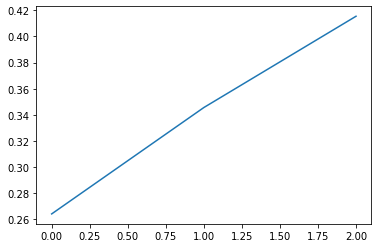

In [134]:
plt.plot(coherence_scores)

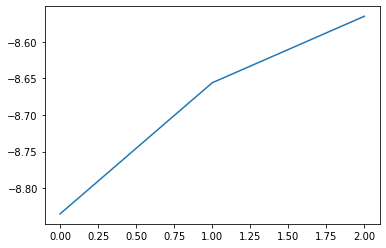

In [135]:
plt.plot(perplexity_scores)

In [136]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.329054  0.013594       1        1  26.403480
3      0.074995  0.118203       2        1  17.621919
5      0.017446  0.061892       3        1  15.115124
4      0.070312 -0.216929       4        1  13.596043
0      0.072042  0.061833       5        1  13.548253
6      0.080410  0.088059       6        1   7.731908
2      0.013849 -0.126652       7        1   5.983273, topic_info=                        Term        Freq       Total Category  logprob  loglift
7000                       n  264.000000  264.000000  Default  30.0000  30.0000
18618            rittenhouse  166.000000  166.000000  Default  29.0000  29.0000
9659                   jones  126.000000  126.000000  Default  28.0000  28.0000
510                   police  783.000000  783.000000  Default  27.0000  27.0000
12355                 arbery  175.000000  175.000000  Default  26.0000  26.0000
...                      ...         ...         ...      ...      ...      ...
334                      gmt   18.597371  251.110437   Topic7  -6.2822   0.2133
172    classarticletimestamp   18.597364  251.110428   Topic7  -6.2822   0.2133
1144                      10   17.056727  106.619544   Topic7  -6.3686   0.9835
665                      two   18.597244  403.015898   Topic7  -6.2822  -0.2598
714                      xa0   17.056752  169.675795   Topic7  -6.3686   0.5189

[497 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1144      1  0.497095   10
1144      2  0.037517   10
1144      3  0.037517   10
1144      4  0.168825   10
1144      5  0.112550   10
...     ...       ...  ...
2482      3  0.135148    –
2482      4  0.261849    –
2482      5  0.152042    –
2482      6  0.042234    –
2482      7  0.143595    –

[1051 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 5, 1, 7, 3])

In [137]:
topics = pd.DataFrame(ldamodel[corpus])
topics = topics.applymap(lambda x: Get_Tuple_Value(x,1))

In [138]:
column_names_raw = pd.DataFrame(ldamodel.print_topics(num_topics = optimal_n_topics, num_words = 5))[1]
column_names = []
for name in column_names_raw:
  name = str(re.findall('"([^"]*)"',name))
  column_names.append(name)
topics.columns = column_names

## Sentiment Analysis

In [139]:
vader = SentimentIntensityAnalyzer()
sentiment_scores = []
for doc in doc_complete:
  sentiment_scores.append(vader.polarity_scores(doc))

In [140]:
sentiments = pd.DataFrame(sentiment_scores)

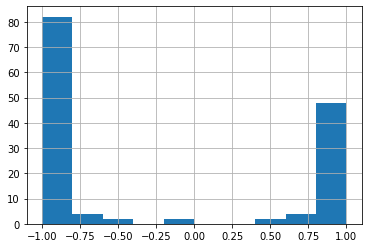

In [141]:
sentiments['compound'].hist()

## Regression Analysis

In [142]:
regression_analysis_data = pd.concat([topics,sentiments], axis = 1)
len(regression_analysis_data)

144

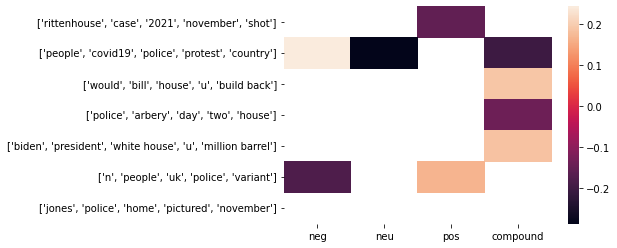

In [143]:
sentiment_variables = ["neg","neu","pos","compound"]
corr = regression_analysis_data.corr()
p_values = regression_analysis_data.corr(method = Pearsonr_Pval)
vis_data = Filter_By_P_Value(corr,p_values,ALPHA)
sb.heatmap(vis_data.loc[:,sentiment_variables].drop(sentiment_variables, axis = 0))

In [144]:
execution_time = time.time() - start_time
execution_time

276.0681035518646